Last section demonstrated how a neural network can fit into data by applying a simple neural network into a regression problem with two independent variables and one dependent variable.\
Now, we will attempt to train a FCN in a classification task. More specfically, we start with a binary classification task on an image dataset of handwritten digits. Here, we concentrate on classifying whether an image is the number 1 or not. Note that this is for demonstrative purporses only and the choice of differentiating between the number 1 and other numbers is purely to preferences.

In [13]:
import torch
from torch import nn

from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Grayscale

gpu_available = torch.cuda.is_available()
print(f'{gpu_available=}')

gpu_available=True


In [ ]:
import sys
sys.path.append('../..')

import math
import matplotlib.pyplot as plt

from CustomDL.loops.classification import train_loop, test_loop

# Load MNIST dataset

In [3]:
digits_dataset = MNIST(
    root='../../data', # the folder where data eixsts/is stored,
    download=True,
    transform=ToTensor() # The image are PIL format, this transform to Tensor objects
)
print(digits_dataset.data.shape)

train_data, test_data = random_split(digits_dataset, [.8, .2])

torch.Size([60000, 28, 28])


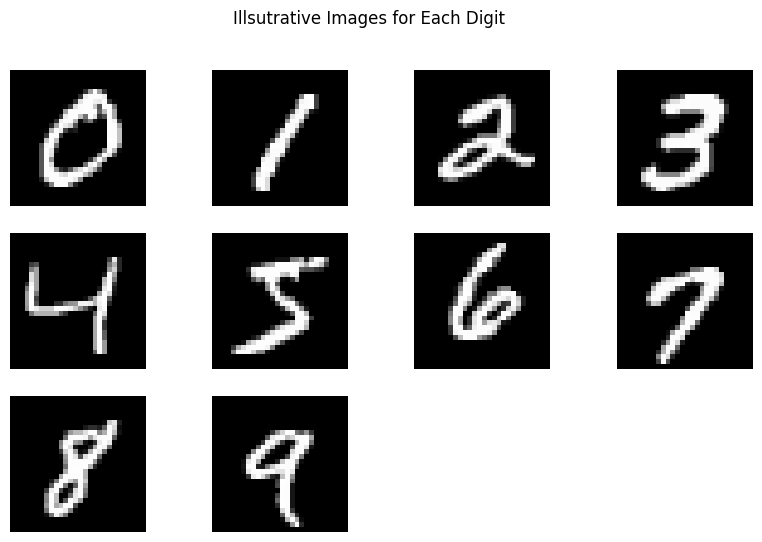

In [4]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
fig.suptitle('Illsutrative Images for Each Digit')

labels = digits_dataset.targets
num_lab = torch.tensor(labels.unique().shape[0])
rows = int(torch.sqrt(num_lab))
cols = int(torch.ceil(num_lab / rows))
for tens_number in labels.unique():
  number = tens_number.item()
  idx = torch.argmax((labels == number).int())
  img = digits_dataset[idx][0].squeeze()

  ax = fig.add_subplot(rows, cols, number + 1)
  ax.axis('off')
  ax.imshow(img, cmap='gray')

Before defining a model and training it, we should transform the labels for the classfication tasks.\
Here, we just change all numbers not equal to 1 to the label 0.

In [5]:
mask = digits_dataset.targets != 1
digits_dataset.targets[mask] = 0
digits_dataset.targets

tensor([0, 0, 0,  ..., 0, 0, 0])

In [6]:
digits_dataset.targets[train_data.indices].shape

torch.Size([48000])

In [7]:
train_targets = digits_dataset.targets[train_data.indices]
mask_0 = train_targets == 0

weights_0 = train_targets[mask_0].shape[0] / train_targets.shape[0]
weights_1 = 1 - weights_0
weights_0 = 1 / weights_0
weights_1 = 1 / weights_1

weights_0, weights_1

(1.1269986616890892, 8.874098724348304)

In [8]:
weights_by_sample = torch.zeros(train_targets.shape)
weights_by_sample[mask_0] = weights_0
weights_by_sample[~mask_0] = weights_1
weights = weights_by_sample#.tolist()
weights

tensor([8.8741, 1.1270, 1.1270,  ..., 1.1270, 1.1270, 8.8741])

# Defining a Model

In [ ]:
class OneClassfier(nn.Module):
    def __init__(self,
        hidden_dims: int,
        activation_fn: nn.Module
    ):
        super().__init__()
        self.layers = nn.Sequential(
            # images in the MNIST dataset are (1, 28, 28)
            # to pass the images as vectors to do linear transformations,
            # we need to flatten it.
            # However, the inputs to the neural netwrk is of shape (batch_size, 1, 28, 28)
            # So we only want to flatten the last 3 dimensions to get (batch_size, 1 * 28 * 28)
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dims),
            activation_fn,
            nn.Linear(hidden_dims, hidden_dims),
            activation_fn,
            nn.Linear(hidden_dims, hidden_dims),
            activation_fn,
            nn.Linear(hidden_dims, 2)
        )

    def forward(self, image):
        return self.layers(image)

# Training and Evaluation

In [ ]:
def run_epochs(
    epochs: int,
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module
):
    num_dig = int(math.log10(epochs)) + 1

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1:0>{num_dig}}/{epochs}")
        loss = train_loop(model, train_loader, loss_fn, optimizer,
                          use_gpu=gpu_available)
        print(f"  Average Training Loss: {sum(loss) / len(loss):.6f}")

        loss, acc = test_loop(model, test_loader, loss_fn, True,
                               use_gpu=gpu_available)
        print(f"  Average Eval Loss: {loss:.6f} | {acc * 100:.4f}%")

In [10]:
batch_size = 64
learning_rate = 0.001

weighted_sampler = WeightedRandomSampler(weights, len(weights))
train_loader = DataLoader(train_data, batch_size, sampler=weighted_sampler)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

model = OneClassfier(50, nn.Sigmoid())
if gpu_available:
    model.cuda()

sml = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

In [19]:
epochs = 10

run_epochs(
    epochs, model,
    train_loader, test_loader,
    sml, optimizer
)

Epoch  1/10 || Average Loss: 0.704341 | 11.7500%
Epoch  2/10 || Average Loss: 0.694994 | 11.7500%
Epoch  3/10 || Average Loss: 0.691283 | 88.2500%
Epoch  4/10 || Average Loss: 0.692976 | 71.4667%
Epoch  5/10 || Average Loss: 0.705679 | 11.7500%
Epoch  6/10 || Average Loss: 0.696004 | 11.7500%
Epoch  7/10 || Average Loss: 0.693874 | 11.8000%
Epoch  8/10 || Average Loss: 0.689642 | 88.2500%
Epoch  9/10 || Average Loss: 0.688783 | 88.2500%
Epoch 10/10 || Average Loss: 0.688877 | 88.2500%


In [21]:
torch.save(
    {'epochs': epochs, 'hidden_dims': 50, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()},
    './output/one_class_1.pth'
)

# Testing on new images

In [12]:
model.cpu()
model.eval()

OneClassfier(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [15]:
import torchvision

In [27]:
sample_img = torchvision.io.read_image('./data/num1.1.png')
sample_img = Grayscale(1)(sample_img[:3])
sample_img = (255 - sample_img) / 255
plt.imshow(sample_img[0], cmap='gray_r')

In [28]:
pred_vals = model(sample_img.unsqueeze(0))
prediction = pred_vals.argmax().item()

print(f"""Output values:
{pred_vals.detach()}
Prediction: {prediction}""")

Output values:
tensor([[0.1470, 0.1360]])
Prediction: 0


As you can see, pretty terrible predictions. This is also shown in our test evaluations, with quite low accuracy.\
During training, sometimes the accuracy jumps, which can comes from the fact that the test data have not been balanced.\
To improve this, one can use a different accuracy metrics to better capture the performance. Furthermore, the network here used a Sigmoid activation function which is not necessarily the best kind for the hidden layers due to its properties.

Anyway, this is just a demonstrate how one can use the FCN architecture in a binary classification problem. The next section moves on to using the FCN for the MNIST dataset as a whole.